In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Load the datasets
train_transaction = pd.read_csv('train_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_identity = pd.read_csv('test_identity.csv')

/home/datascience/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Merge the datasets on TransactionID
train_data = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test_data = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# Display the first few rows of the merged datasets
print(train_data.head())
print(test_data.head())

print("Size of train data:", train_data.shape)
print("Size of test data:", test_data.shape)

# Check for missing values
print("Missing values in train data:", train_data.isnull().sum().sum())
print("Missing values in test data:", test_data.isnull().sum().sum())

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0        NaN             NaN    NaN   Na

In [3]:
# Define features and target
X = train_data.drop(columns=['isFraud', 'TransactionID'])
y = train_data['isFraud']

# Handle categorical variables and missing values using a pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply undersampling to balance the dataset
fraud = train_data[train_data['isFraud'] == 1]
non_fraud = train_data[train_data['isFraud'] == 0]

non_fraud_downsampled = resample(non_fraud,
                                 replace=False,
                                 n_samples=len(fraud),
                                 random_state=42)

train_data_balanced = pd.concat([fraud, non_fraud_downsampled])

X_balanced = train_data_balanced.drop(columns=['isFraud', 'TransactionID'])
y_balanced = train_data_balanced['isFraud']

# Sample a subset of the balanced data to reduce computational load
X_sampled, _, y_sampled, _ = train_test_split(X_balanced, y_balanced, test_size=0.9, random_state=42, stratify=y_balanced)

# Split the sampled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled)

In [4]:
# Initialize models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'GradientBoosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}

results = {}

In [5]:
# Train and evaluate models
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_val)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    
    conf_matrix = confusion_matrix(y_val, y_pred)
    class_report = classification_report(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    results[model_name] = {
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'roc_auc': roc_auc
    }

/home/datascience/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/datascience/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/datascience/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
# Print results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("\nClassification Report:")
    print(result['classification_report'])
    print("\nROC AUC Score:", result['roc_auc'])
    print("\n")

Model: RandomForest
Confusion Matrix:
[[336  78]
 [ 78 335]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       414
           1       0.81      0.81      0.81       413

    accuracy                           0.81       827
   macro avg       0.81      0.81      0.81       827
weighted avg       0.81      0.81      0.81       827


ROC AUC Score: 0.8860815758383923


Model: LogisticRegression
Confusion Matrix:
[[341  73]
 [124 289]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.82      0.78       414
           1       0.80      0.70      0.75       413

    accuracy                           0.76       827
   macro avg       0.77      0.76      0.76       827
weighted avg       0.77      0.76      0.76       827


ROC AUC Score: 0.8263384449825127


Model: GradientBoosting
Confusion Matrix:
[[342  72]
 [ 89 324]]

Classification Report:
       

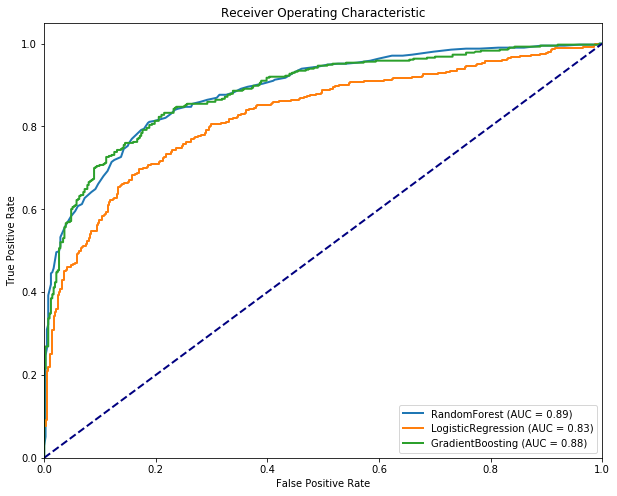

In [8]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_val, models[model_name].predict_proba(preprocessor.transform(X_val))[:, 1])
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()